<a href="https://colab.research.google.com/github/julwdo/Algorithms-project/blob/main/Algorithms_Project_JW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set the fraction of data to use (e.g., 0.5 for 50%)
DATA_FRACTION = 1.0

assert 0 < DATA_FRACTION <= 1, 'ERROR: DATA_FRACTION must be between 0 and 1 (exclusive).'

In [ ]:
# Download all necessary files and libraries
!apt-get install openjdk-17-jdk-headless -qq > /dev/null # OpenJDK 17
!wget --show-progress https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz # Apache Spark 3.5.5 with Hadoop 3 support
!tar xf spark-3.5.5-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark
!pip install kaggle

--2025-03-20 10:53:02--  https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400724056 (382M) [application/x-gzip]
Saving to: ‘spark-3.5.5-bin-hadoop3.tgz’

spark-3.5.5-bin-had 100%[===================>] 382.16M  41.0MB/s    in 6.5s    

2025-03-20 10:53:08 (58.8 MB/s) - ‘spark-3.5.5-bin-hadoop3.tgz’ saved [400724056/400724056]



In [ ]:
# Import necessary libraries
import os
import findspark
from pyspark.sql import SparkSession
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from itertools import combinations
from collections import defaultdict
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set up Spark
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.5.5-bin-hadoop3'

findspark.init()
findspark.find()

spark = SparkSession.builder.appName('FrequentItemsetMining').getOrCreate()
spark

In [ ]:
# Download the Kaggle datasets into "data" folder

# Create "data" folder
os.makedirs('data', exist_ok=True)

# Authenticate Kaggle API
kaggle_username = '' # Insert your Kaggle credentials
kaggle_key = ''

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

# Download the datasets and unzip
!kaggle datasets download mohamedbakhet/amazon-books-reviews -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.06G/1.06G [00:09<00:00, 194MB/s]
100% 1.06G/1.06G [00:09<00:00, 118MB/s]


In [ ]:
# Load the dataset containing reviews
schema = T.StructType([
    T.StructField('Id', T.StringType(), True),
    T.StructField('Title', T.StringType(), True),
    T.StructField('Price', T.FloatType(), True),
    T.StructField('User_id', T.StringType(), True),
    T.StructField('profileName', T.StringType(), True),
    T.StructField('review/helpfulness', T.StringType(), True),
    T.StructField('review/score', T.FloatType(), True),
    T.StructField('review/time', T.IntegerType(), True),
    T.StructField('review/summary', T.StringType(), True),
    T.StructField('review/text', T.StringType(), True),
])

reviews = spark.read.csv('data/Books_rating.csv', schema=schema, header=True, escape='"')
reviews.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: float (nullable = true)
 |-- review/time: integer (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [ ]:
# Sample the dataset according to DATA_FRACTION
if DATA_FRACTION < 1:
    print(f'Sampling {DATA_FRACTION * 100:.0f}% of the dataset.')
    reviews = reviews.sample(False, DATA_FRACTION, 42)
else:
    print('Using the entire dataset.')

Using the entire dataset.


In [ ]:
n_rows, n_columns = reviews.count(), len(reviews.columns)
print(f'The dataset contains {n_rows} rows and {n_columns} columns.')

The dataset contains 3000000 rows and 10 columns.


In [ ]:
print('First few rows of the dataset:')
reviews.show(10)

First few rows of the dataset:
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|        Id|               Title|Price|       User_id|         profileName|review/helpfulness|review/score|review/time|      review/summary|         review/text|
+----------+--------------------+-----+--------------+--------------------+------------------+------------+-----------+--------------------+--------------------+
|1882931173|Its Only Art If I...| NULL| AVCGYZL8FQQTD|Jim of Oz "jim-of...|               7/7|         4.0|  940636800|Nice collection o...|This is only for ...|
|0826414346|Dr. Seuss: Americ...| NULL|A30TK6U7DNS82R|       Kevin Killian|             10/10|         5.0| 1095724800|   Really Enjoyed It|I don't care much...|
|0826414346|Dr. Seuss: Americ...| NULL|A3UH4UZ4RSVO82|        John Granger|             10/11|         5.0| 1078790400|Essential for eve...|If people become ..

In [ ]:
# Select and rename relevant columns
reviews = reviews.select('Id', 'Title', 'User_id', 'review/score')
reviews = reviews.withColumnRenamed('Id', 'book_id')\
.withColumnRenamed('Title', 'title')\
.withColumnRenamed('User_id', 'user_id')\
.withColumnRenamed('review/score', 'rating')
reviews.printSchema()

root
 |-- book_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: float (nullable = true)



In [ ]:
# Check for missing values
print('Summary of missing values:')
reviews.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in reviews.columns]).show()

Summary of missing values:
+-------+-----+-------+------+
|book_id|title|user_id|rating|
+-------+-----+-------+------+
|      0|  208| 561787|     0|
+-------+-----+-------+------+



In [ ]:
# Drop rows with missing values
reviews = reviews.dropna()
print(f'Remaining rows: {reviews.count()}')

Remaining rows: 2438018


In [ ]:
# Check for empty strings in book_id, title and user_id columns
columns = ['book_id', 'title', 'user_id']

for column in columns:
  count = reviews.filter(F.col(column) == '').count()
  if count > 0:
    print(f'Warning: "{column}" contains {count} empty string(s).')
  else:
    print(f'"{column}" has no empty strings.')

"book_id" has no empty strings.
"title" has no empty strings.
"user_id" has no empty strings.


In [ ]:
# Check for unique values in rating column
print('Unique values in "rating":')
reviews.select('rating').distinct().show()

Unique values in "rating":
+------+
|rating|
+------+
|   5.0|
|   2.0|
|   3.0|
|   1.0|
|   4.0|
+------+



In [ ]:
# Check distribution of values in rating column
print('Distribution of values in "rating":')
reviews.groupBy('rating').count().show()

Distribution of values in "rating":
+------+-------+
|rating|  count|
+------+-------+
|   5.0|1462175|
|   2.0| 119629|
|   3.0| 212908|
|   1.0| 151152|
|   4.0| 492154|
+------+-------+



In [ ]:
# Filter for 'liked' books, i.e., rating 4. or 5. and drop rating column
reviews = reviews.filter(F.col('rating') >= 4.).drop('rating')
print(f'Remaining rows: {reviews.count()}')

Remaining rows: 1954329


In [ ]:
# Some books have 2 or more different book_ids
reviews.groupBy('title').agg(F.countDistinct('book_id')).filter(F.col('count(DISTINCT book_id)') > 1).show(5)

+--------------------+-----------------------+
|               title|count(DISTINCT book_id)|
+--------------------+-----------------------+
|Wandering under sail|                      2|
|                   K|                      2|
|           Amaryllis|                      3|
|Central Problems ...|                      2|
|The Keepers of th...|                      2|
+--------------------+-----------------------+
only showing top 5 rows



In [ ]:
# Generate unique title-user_id pairs
reviews = reviews.select('title', 'user_id').dropDuplicates()
print(f'Remaining rows: {reviews.count()}')

# Result:
# E.g., If user X 'liked' book A, but under 2 (or more) different book_ids -> only one pair user X-book A will be left
# E.g., If user X 'liked' book A under the same book_id, but twice (or more times) -> only one pair user X-book A will be left

Remaining rows: 1690999


In [ ]:
print('First few rows of the dataset:')
reviews.show(5)

First few rows of the dataset:
+--------------------+--------------+
|               title|       user_id|
+--------------------+--------------+
|Night World: Daug...| A5PTRZJFN2SVJ|
|    The Food Of Love|A2XKP1M4MOYS3Q|
|The Scarletti Cur...|A28185JY1JJEYD|
|Economics in one ...| ATMOVG6SV5D2B|
|Economics in one ...|A3LH3VTHCH45KM|
+--------------------+--------------+
only showing top 5 rows



In [ ]:
# Generate a new book_id based on title
book_window = Window.orderBy('title')
reviews = reviews.withColumn('book_id', F.dense_rank().over(book_window))

# Convert user_id into an integer id
user_window = Window.orderBy('user_id')
reviews = reviews.withColumn('user_id_int', F.dense_rank().over(user_window))

print('First few rows of the dataset:')
reviews.show(5)

First few rows of the dataset:
+--------------------+--------------------+-------+-----------+
|               title|             user_id|book_id|user_id_int|
+--------------------+--------------------+-------+-----------+
|This Calder Range...|A00109803PZJ91RLT...| 175061|          1|
|The Queen of Harl...|A00117421L76WVWG4...| 160449|          2|
|The Richest Man i...|A0015610VMNR0JC9XVL1| 161300|          3|
|The richest man i...|A0015610VMNR0JC9XVL1| 173040|          3|
|The richest man i...|A0015610VMNR0JC9XVL1| 173041|          3|
+--------------------+--------------------+-------+-----------+
only showing top 5 rows



In [ ]:
# Is the new book_id unique per title?
reviews.groupBy('title').agg(F.countDistinct('book_id')).filter(F.col('count(DISTINCT book_id)') != 1).show()

+-----+-----------------------+
|title|count(DISTINCT book_id)|
+-----+-----------------------+
+-----+-----------------------+



In [ ]:
# Are there collisions?
reviews.groupBy('book_id').agg(F.countDistinct('title')).filter(F.col('count(DISTINCT title)') != 1).show()

+-------+---------------------+
|book_id|count(DISTINCT title)|
+-------+---------------------+
+-------+---------------------+



In [ ]:
# Create a mapping table: book_id->title
book_id_to_title = reviews.select('book_id', 'title').distinct()

In [ ]:
# Is the integer user_id unique per user_id?
reviews.groupBy('user_id').agg(F.countDistinct('user_id_int')).filter(F.col('count(DISTINCT user_id_int)') != 1).show()

+-------+---------------------------+
|user_id|count(DISTINCT user_id_int)|
+-------+---------------------------+
+-------+---------------------------+



In [ ]:
# Are there collisions?
reviews.groupBy('user_id_int').agg(F.countDistinct('user_id')).filter(F.col('count(DISTINCT user_id)') != 1).show()

+-----------+-----------------------+
|user_id_int|count(DISTINCT user_id)|
+-----------+-----------------------+
+-----------+-----------------------+



In [ ]:
# Select and rename relevant columns
data = reviews.select('user_id_int', 'book_id')
data = data\
.withColumnRenamed('user_id_int', 'basket_id')\
.withColumnRenamed('book_id', 'item_id') # Universal names: user_id -> basket_id, book_id -> item_id
data.printSchema()

root
 |-- basket_id: integer (nullable = false)
 |-- item_id: integer (nullable = false)



In [ ]:
# Filter out basket_ids which correspond to only one item_id
n_items_per_basket = data.groupBy('basket_id').count()
data = data.join(n_items_per_basket, on='basket_id').filter(F.col('count') > 1).drop('count')
print(f'Remaining rows: {data.count()}')

Remaining rows: 1076095


In [ ]:
# Create baskets by grouping items by basket_id
baskets = data\
.rdd\
.groupByKey()\
.mapValues(set)\
.values()

print('First few baskets:')
baskets.top(5)

First few baskets:


[{40525, 127772, 168205, 188960},
 {13483, 127770},
 {161300, 173040, 173041},
 {150661, 150662, 150663, 150664, 150665},
 {68976, 68977}]

In [ ]:
n_baskets = baskets.count()
print(f'Total baskets: {n_baskets}')

Total baskets: 221587


In [ ]:
# Force the use of two partitions
if baskets.getNumPartitions() < 2:
  baskets = baskets.repartition(2)
print(f'Number of partitions: {baskets.getNumPartitions()}')

Number of partitions: 2


In [ ]:
# Define functions to perform frequent itemset mining (SON+Apriori)
def generate_candidate_itemsets(frequent_subsets, k, frequent_itemsets):
  candidate_itemsets = set()

  for subset1, subset2 in combinations(frequent_subsets, 2):
    set1, set2 = set(subset1), set(subset2)
    common_items = set1 & set2
    if len(common_items) == k - 2:
      candidate_itemset = tuple(sorted(set1 | set2))
      if all(subset in frequent_itemsets for subset in combinations(candidate_itemset, k - 1)):
        candidate_itemsets.add(candidate_itemset)

  return list(candidate_itemsets)

def apriori(baskets, min_count, k_max):
  baskets = list(baskets) # Convert iterator to a list

  item_counts = defaultdict(int)
  for basket in baskets:
    for item in basket:
      item_counts[item] += 1

  frequent_items = {item for item, count in item_counts.items() if count >= min_count}
  output_frequent_itemsets = [(tuple([item]), 1) for item in frequent_items]

  for k in range(2, k_max + 1):

    counts = defaultdict(int)
    for i, basket in enumerate(baskets):
      filtered_basket = basket & frequent_items
      if len(filtered_basket) < k:
        continue

      if k == 2:
        for pair in combinations(filtered_basket, k):
          sorted_pair = tuple(sorted(pair))
          counts[sorted_pair] += 1
      else:
        frequent_subsets = [subset for subset in combinations(filtered_basket, k - 1) if subset in frequent_itemsets]
        if len(frequent_subsets) < 2:
          continue

        candidate_itemsets = generate_candidate_itemsets(frequent_subsets, k, frequent_itemsets)
        for candidate_itemset in candidate_itemsets:
          counts[candidate_itemset] += 1

    frequent_itemsets = {itemset for itemset, count in counts.items() if count >= min_count}
    if not frequent_itemsets:
      break

    output_frequent_itemsets.extend([(itemset, 1) for itemset in frequent_itemsets])
    frequent_items = {item for itemset in frequent_itemsets for item in itemset}

  return output_frequent_itemsets

def count_occurrences(baskets, itemsets):
  baskets = list(baskets)

  counts = defaultdict(int)

  for itemset in itemsets:
    itemset_set = set(itemset)
    for basket in baskets:
      if itemset_set.issubset(basket):
        counts[tuple(sorted(itemset_set))] += 1

  return list(counts.items())

def son(baskets, min_support, k_max):
  n_baskets = baskets.count()
  n_partitions = baskets.getNumPartitions()

  local_min_count = int(n_baskets/n_partitions * min_support)
  global_min_count = int(n_baskets * min_support)

  start_time = time.time()

  local_frequent_itemsets = (
      baskets
      .mapPartitions(lambda partition: apriori(partition, local_min_count, k_max))
      .reduceByKey(lambda x, y: x) # or .groupByKey()
      .keys()
      .collect()
      )

  global_frequent_itemsets = (
      baskets
      .mapPartitions(lambda partition: count_occurrences(partition, local_frequent_itemsets))
      .reduceByKey(lambda x, y: x + y)
      .filter(lambda x: x[1] >= global_min_count)
      .collect()
      )

  n_global_frequent_itemsets = len(global_frequent_itemsets)

  end_time = time.time()
  execution_time = end_time - start_time

  return {
      'n_baskets': n_baskets,
      'min_support': min_support,
      'k_max': k_max,
      'execution_time': execution_time,
      'n_frequent_itemsets': n_global_frequent_itemsets,
      'frequent_itemsets': global_frequent_itemsets
      }

In [ ]:
# Mine for frequent pairs (SON+Apriori)
min_support = 0.0001 # Minimum support: ~0.01% of all baskets
k_max = 2

pair_mining_results = son(baskets, min_support, k_max)
pair_mining_execution_time = pair_mining_results['execution_time']
frequent_pairs = pair_mining_results['frequent_itemsets']

print(f'Execution time: {pair_mining_execution_time:.4f} seconds')

for k in range(1, k_max + 1):
  n_itemsets = sum(1 for itemset, _ in frequent_pairs if len(itemset) == k)
  print(f'Number of frequent {k}-itemsets found: {n_itemsets}')

Execution time: 244.0376 seconds
Number of frequent 1-itemsets found: 7289
Number of frequent 2-itemsets found: 9565


In [ ]:
# Define a function to mine for association rules
def association_rules(frequent_itemsets, n_baskets, min_confidence=0.0):

  association_rules = []
  frequent_itemsets_dict = {itemset: count for itemset, count in frequent_itemsets}

  for itemset, count in frequent_itemsets_dict.items():

    k = len(itemset)
    support = count/n_baskets

    if k > 1:
      subsets_of_itemset = list(combinations(itemset, k - 1))

      for subset in subsets_of_itemset:
        antecedent = subset
        consequent = tuple(set(itemset) - set(antecedent))

        support_antecedent = frequent_itemsets_dict[antecedent]/n_baskets
        support_consequent = frequent_itemsets_dict[consequent]/n_baskets

        confidence = support / support_antecedent
        interest = confidence - support_consequent

        if confidence >= min_confidence:
          association_rules.append((antecedent, consequent, support, confidence, interest))

  return pd.DataFrame(
      association_rules,
      columns=['antecedents', 'consequents', 'support', 'confidence', 'interest']
      )

In [ ]:
# Mine for association rules
association_rules = association_rules(frequent_pairs, n_baskets)

association_rules['antecedents'] = association_rules['antecedents'].apply(lambda x: x[0]) # From e.g., (6175,) to 6175
association_rules['consequents'] = association_rules['consequents'].apply(lambda x: x[0])

print(f'Number of association rules found: {association_rules.shape[0]}')
print(f'First few association rules:')
association_rules.head(5)

Number of association rules found: 19130
First few association rules:


,antecedents,consequents,support,confidence,interest
0,6175,188821,0.001119,0.992000,0.990881
1,188821,6175,0.001119,1.000000,0.998872
2,100728,107736,0.000149,0.191860,0.190425
3,107736,100728,0.000149,0.103774,0.102997
4,152668,171532,0.000099,1.000000,0.999901


In [ ]:
# Filter out rules:
# 1) with negative or 0 interest,
# 2) with confidence higher than (or equal to) 0.8
association_rules_filtered = association_rules[(association_rules['interest'] > 0) &
 (association_rules['confidence'] < 0.8)]\
 .sort_values('interest', ascending=False)

print(f'Remaining association rules: {association_rules_filtered.shape[0]}')
print(f'First few association rules (sorted by descending interest):')
association_rules_filtered.head(5)

Remaining association rules: 10500
First few association rules (sorted by descending interest):


,antecedents,consequents,support,confidence,interest
12586,55499,81528,0.000190,0.792453,0.792155
15444,117239,165802,0.000167,0.787234,0.786507
4647,146315,146313,0.000253,0.777778,0.777525
11982,146312,146313,0.000253,0.777778,0.777525
6063,159101,108685,0.000244,0.771429,0.771185


In [ ]:
# Randomly select a book from antecedents and get a recommendation
purchased_book_id = np.random.choice(association_rules_filtered['antecedents'])
purchased_book_title = book_id_to_title\
.filter(F.col('book_id') == purchased_book_id)\
.select('title')\
.collect()[0]['title']

recommended_book_id = association_rules_filtered.loc[
    association_rules_filtered['antecedents'] == purchased_book_id, 'consequents'
    ].iloc[0]

recommended_book_title = book_id_to_title\
.filter(F.col('book_id') == recommended_book_id)\
.select('title')\
.collect()[0]['title']

print(f"Readers who enjoyed '{purchased_book_title}' often also liked '{recommended_book_title}'.")

Readers who enjoyed 'Emma (Summer Classics)' often also liked 'Pride & Prejudice (New Windmill)'.


Performing scalability tests on the full dataset.
Testing fraction: 0.1
Testing fraction: 0.2
Testing fraction: 0.4
Testing fraction: 0.8
Testing fraction: 1.6
Testing fraction: 3.2
Testing fraction: 6.4


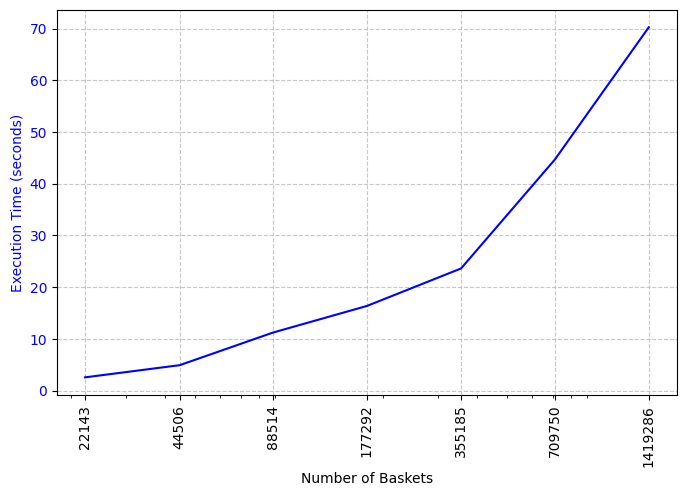

In [ ]:
# Test scalability with different subsets of the dataset
if DATA_FRACTION == 1:
  print('Performing scalability tests on the full dataset.')

  fractions = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]

  min_support = 0.001 # Minimum support: ~0.1% of all baskets
  k_max = 2

  fraction_scalability_results = []

  for fraction in fractions:
    print(f'Testing fraction: {fraction}')
    with_replacement = fraction > 1 # Allow for sampling with replacement for fractions greater than 1
    subset = baskets.sample(with_replacement, fraction, 42)
    fraction_result = son(subset, min_support, k_max)
    fraction_result['n_baskets'] = subset.count()
    fraction_scalability_results.append(fraction_result)

  # Plot the results
  n_baskets_values = [r['n_baskets'] for r in fraction_scalability_results]
  execution_times = [r['execution_time'] for r in fraction_scalability_results]

  plt.figure(figsize=(8, 5))
  plt.plot(n_baskets_values, execution_times, 'b')
  plt.xlabel('Number of Baskets')
  plt.ylabel('Execution Time (seconds)', color='b')
  plt.tick_params(axis='y', labelcolor='b')

  plt.xscale('log') # Use log scale for better readability

  n_baskets_labels = [n for n in n_baskets_values]
  plt.xticks(n_baskets_values, n_baskets_labels, rotation=90)

  plt.grid(True, linestyle='--', alpha=0.7)
  plt.show()

else:
  print(f'Not performing scalability tests due to DATA_FRACTION being {DATA_FRACTION}.')

In [ ]:
if DATA_FRACTION == 1:
  prev_execution_time = None
  prev_n_baskets = None

  for r in fraction_scalability_results:
    n_baskets = r['n_baskets']
    n_frequent_itemsets = r['n_frequent_itemsets']
    execution_time = r['execution_time']

    time_ratio = execution_time / prev_execution_time if prev_execution_time else None
    basket_ratio = n_baskets / prev_n_baskets if prev_n_baskets else None
    scaling_ratio = time_ratio / basket_ratio if time_ratio is not None and basket_ratio is not None else None

    if time_ratio is not None and basket_ratio is not None and scaling_ratio is not None:
      print(f'Number of Baskets: {n_baskets} -> Frequent Itemsets: {n_frequent_itemsets} '
            f'(Baskets Ratio: {basket_ratio:.2f}x), Execution Time: {execution_time:.2f} '
            f'(Time Ratio: {time_ratio:.2f}x), Scaling Ratio: {scaling_ratio:.2f}')
    else:
      print(f'Number of Baskets: {n_baskets} -> Frequent Itemsets: {n_frequent_itemsets}, '
            f'Execution Time: {execution_time:.2f}')

    prev_execution_time = execution_time
    prev_n_baskets = n_baskets

Number of Baskets: 22143 -> Frequent Itemsets: 1586, Execution Time: 2.56
Number of Baskets: 44506 -> Frequent Itemsets: 1530 (Baskets Ratio: 2.01x), Execution Time: 4.91 (Time Ratio: 1.92x), Scaling Ratio: 0.95
Number of Baskets: 88514 -> Frequent Itemsets: 1582 (Baskets Ratio: 1.99x), Execution Time: 11.21 (Time Ratio: 2.28x), Scaling Ratio: 1.15
Number of Baskets: 177292 -> Frequent Itemsets: 1516 (Baskets Ratio: 2.00x), Execution Time: 16.37 (Time Ratio: 1.46x), Scaling Ratio: 0.73
Number of Baskets: 355185 -> Frequent Itemsets: 1533 (Baskets Ratio: 2.00x), Execution Time: 23.62 (Time Ratio: 1.44x), Scaling Ratio: 0.72
Number of Baskets: 709750 -> Frequent Itemsets: 1525 (Baskets Ratio: 2.00x), Execution Time: 44.68 (Time Ratio: 1.89x), Scaling Ratio: 0.95
Number of Baskets: 1419286 -> Frequent Itemsets: 1473 (Baskets Ratio: 2.00x), Execution Time: 70.26 (Time Ratio: 1.57x), Scaling Ratio: 0.79


Performing scalability tests on the full dataset.
Testing minimum support threshold: 0.01
Testing minimum support threshold: 0.005
Testing minimum support threshold: 0.0025
Testing minimum support threshold: 0.00125
Testing minimum support threshold: 0.000625
Testing minimum support threshold: 0.0003125
Testing minimum support threshold: 0.00015625
Testing minimum support threshold: 7.8125e-05


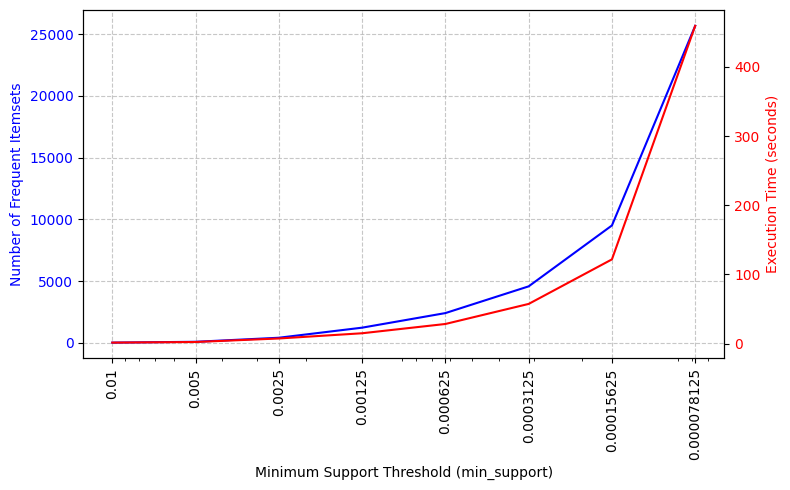

In [ ]:
# Test scalability with different minimum support thresholds
if DATA_FRACTION == 1:
  print('Performing scalability tests on the full dataset.')

  min_support_values = [0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125, 0.00015625, 0.000078125]
  k_max = 2

  support_scalability_results = []

  for min_support in min_support_values:
    print(f'Testing minimum support threshold: {min_support}')
    support_result = son(baskets, min_support, k_max)
    support_scalability_results.append(support_result)

  # Plot the results
  n_frequent_itemsets = [r['n_frequent_itemsets'] for r in support_scalability_results]
  execution_times = [r['execution_time'] for r in support_scalability_results]

  fig, ax1 = plt.subplots(figsize=(8, 5))

  # Plot number of frequent itemsets (Left Y-axis)
  ax1.plot(min_support_values, n_frequent_itemsets, 'b')
  ax1.set_xlabel('Minimum Support Threshold (min_support)')
  ax1.set_ylabel('Number of Frequent Itemsets', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  # Add second Y-axis for execution time
  ax2 = ax1.twinx()
  ax2.plot(min_support_values, execution_times, 'r')
  ax2.set_ylabel('Execution Time (seconds)', color='r')
  ax2.tick_params(axis='y', labelcolor='r')

  ax1.set_xscale('log') # Use log scale for better readability
  ax1.invert_xaxis() # Invert values on X-axis (i.e., decreasing support threshold)

  min_support_labels = [str(s) if i < 7 else format(s, '.9f') for i, s in enumerate(min_support_values)]
  ax1.set_xticks(min_support_values, min_support_labels, rotation=90)
  ax1.grid(True, linestyle='--', alpha=0.7)

  fig.tight_layout()
  plt.show()

else:
  print(f'Not performing scalability tests due to DATA_FRACTION being {DATA_FRACTION}.')

In [ ]:
if DATA_FRACTION == 1:
  prev_execution_time = None
  prev_n_frequent_itemsets = None

  for r in support_scalability_results:
    min_support = r['min_support']
    n_frequent_itemsets = r['n_frequent_itemsets']
    execution_time = r['execution_time']

    time_ratio = execution_time / prev_execution_time if prev_execution_time else None
    itemset_ratio = n_frequent_itemsets / prev_n_frequent_itemsets if prev_n_frequent_itemsets else None
    scaling_ratio = time_ratio / itemset_ratio if time_ratio is not None and itemset_ratio is not None else None

    if time_ratio is not None and itemset_ratio is not None and scaling_ratio is not None:
      print(f'Minimum Support Threshold: {min_support} -> Frequent Itemsets: {n_frequent_itemsets} '
            f'(Ratio: {itemset_ratio:.2f}x), Execution Time: {execution_time:.2f} '
            f'(Ratio: {time_ratio:.2f}x), Scaling Ratio: {scaling_ratio:.2f}')
    else:
      print(f'Minimum Support Threshold: {min_support} -> Frequent Itemsets: {n_frequent_itemsets}, '
            f'Execution Time: {execution_time:.2f}')

    prev_execution_time = execution_time
    prev_n_frequent_itemsets = n_frequent_itemsets

Minimum Support Threshold: 0.01 -> Frequent Itemsets: 15, Execution Time: 1.50
Minimum Support Threshold: 0.005 -> Frequent Itemsets: 82 (Ratio: 5.47x), Execution Time: 2.40 (Ratio: 1.60x), Scaling Ratio: 0.29
Minimum Support Threshold: 0.0025 -> Frequent Itemsets: 410 (Ratio: 5.00x), Execution Time: 7.48 (Ratio: 3.11x), Scaling Ratio: 0.62
Minimum Support Threshold: 0.00125 -> Frequent Itemsets: 1226 (Ratio: 2.99x), Execution Time: 15.02 (Ratio: 2.01x), Scaling Ratio: 0.67
Minimum Support Threshold: 0.000625 -> Frequent Itemsets: 2407 (Ratio: 1.96x), Execution Time: 28.43 (Ratio: 1.89x), Scaling Ratio: 0.96
Minimum Support Threshold: 0.0003125 -> Frequent Itemsets: 4572 (Ratio: 1.90x), Execution Time: 57.40 (Ratio: 2.02x), Scaling Ratio: 1.06
Minimum Support Threshold: 0.00015625 -> Frequent Itemsets: 9504 (Ratio: 2.08x), Execution Time: 121.76 (Ratio: 2.12x), Scaling Ratio: 1.02
Minimum Support Threshold: 7.8125e-05 -> Frequent Itemsets: 25673 (Ratio: 2.70x), Execution Time: 459.17 (

Performing scalability tests on the full dataset.
Testing k_max: 2
Testing k_max: 3
Testing k_max: 4
Testing k_max: 5


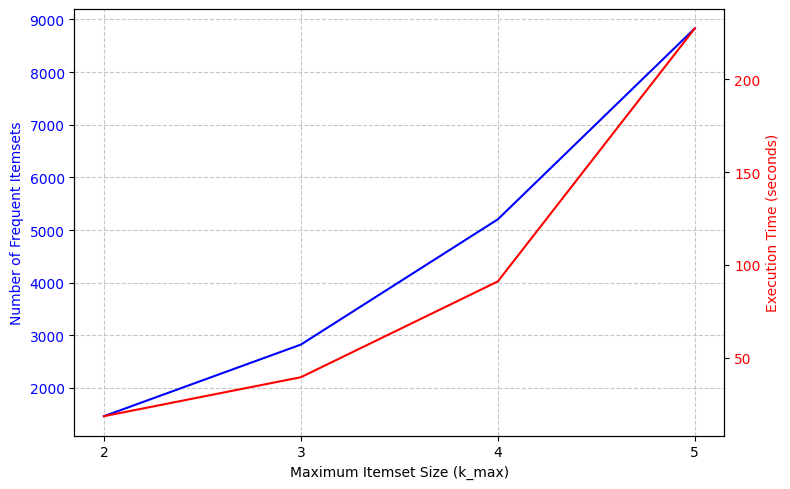

In [ ]:
# Test scalability with different k_max values
if DATA_FRACTION == 1:
  print('Performing scalability tests on the full dataset.')

  min_support = 0.001 # Minimum support: ~0.1% of all baskets
  k_max_values = [2, 3, 4, 5]

  k_max_scalability_results = []

  for k_max in k_max_values:
    print(f'Testing k_max: {k_max}')
    k_max_result = son(baskets, min_support, k_max)
    k_max_scalability_results.append(k_max_result)

  # Plot the results
  k_max_values = [r['k_max'] for r in k_max_scalability_results]
  n_frequent_itemsets = [r['n_frequent_itemsets'] for r in k_max_scalability_results]
  execution_times = [r['execution_time'] for r in k_max_scalability_results]

  fig, ax1 = plt.subplots(figsize=(8, 5))

  # Plot number of frequent itemsets (Left Y-axis)
  ax1.plot(k_max_values, n_frequent_itemsets, 'b')
  ax1.set_xlabel('Maximum Itemset Size (k_max)')
  ax1.set_ylabel('Number of Frequent Itemsets', color='b')
  ax1.tick_params(axis='y', labelcolor='b')

  # Add second Y-axis for execution time
  ax2 = ax1.twinx()
  ax2.plot(k_max_values, execution_times, 'r')
  ax2.set_ylabel('Execution Time (seconds)', color='r')
  ax2.tick_params(axis='y', labelcolor='r')

  # Improve readability
  ax1.set_xticks(k_max_values)
  ax1.grid(True, linestyle='--', alpha=0.7)

  fig.tight_layout()
  plt.show()

else:
  print(f'Not performing scalability tests due to DATA_FRACTION being {DATA_FRACTION}.')

In [ ]:
if DATA_FRACTION == 1:
  prev_execution_time = None
  prev_n_frequent_itemsets = None

  for r in k_max_scalability_results:
    k_max = r['k_max']
    n_frequent_itemsets = r['n_frequent_itemsets']
    execution_time = r['execution_time']

    time_ratio = execution_time / prev_execution_time if prev_execution_time else None
    itemset_ratio = n_frequent_itemsets / prev_n_frequent_itemsets if prev_n_frequent_itemsets else None
    scaling_ratio = time_ratio / itemset_ratio if time_ratio is not None and itemset_ratio is not None else None

    if time_ratio is not None and itemset_ratio is not None and scaling_ratio is not None:
      print(f'k_max: {k_max} -> Frequent Itemsets: {n_frequent_itemsets} '
            f'(Ratio: {itemset_ratio:.2f}x), Execution Time: {execution_time:.2f} '
            f'(Ratio: {time_ratio:.2f}x), Scaling Ratio: {scaling_ratio:.2f}')
    else:
      print(f'k_max: {k_max} -> Frequent Itemsets: {n_frequent_itemsets}, '
            f'Execution Time: {execution_time:.2f}')

    prev_execution_time = execution_time
    prev_n_frequent_itemsets = n_frequent_itemsets

k_max: 2 -> Frequent Itemsets: 1464, Execution Time: 18.53
k_max: 3 -> Frequent Itemsets: 2824 (Ratio: 1.93x), Execution Time: 39.52 (Ratio: 2.13x), Scaling Ratio: 1.11
k_max: 4 -> Frequent Itemsets: 5203 (Ratio: 1.84x), Execution Time: 91.14 (Ratio: 2.31x), Scaling Ratio: 1.25
k_max: 5 -> Frequent Itemsets: 8829 (Ratio: 1.70x), Execution Time: 227.47 (Ratio: 2.50x), Scaling Ratio: 1.47
